# Reinforce, Monte-Carlo Policy-Gradient Control


In [1]:
import os
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import random
from jax import grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [2]:
# Type of environment, options include:
# CartPole-v1
ENV_TYPE = "CartPole-v1"

# Save videos from training
SAVE_VIDEOS = True
VIDEOS_ROOT_DIR = './videos/reinforce/'

In [3]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_actions = env.action_space.n
obs_dims = env.observation_space.shape
obs_upper_bounds = env.observation_space.high
obs_lower_bounds = env.observation_space.low

## Create An $\epsilon$-Greedy Policy 

In [4]:
class _policy_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(64)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x, _ = env.reset()
rng_key = random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[4]   │ float32[2]   │                         │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense      │ float32[4]   │ float32[256] │ bias: float32[256]      │
│         │            │              │              │ kernel: float32[4,256]  │
│         │            │              │              │                         │
│         │            │              │              │ 1,280 (5.1 KB)          │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense      │ float32[256] │ float32[64]  │ bias: float32[64]       │
│         │            │   

In [5]:
def loss_fn(variables, states, actions, weights):
    action_dists = policy_fn.apply(variables, states)
    probs = action_dists[jnp.arange(len(actions)), actions]
    log_probs = jnp.log(probs)
    loss = -(log_probs * weights).mean()
    return loss 

## Learn The Optimal Action-Value Function

In [15]:
# Number of episodes to train on
episodes = 51
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.003

variables = policy_fn.init(rng_key, dummy_x)

optimizer = optax.adam(learning_rate=alpha)
opt_state = optimizer.init(variables)

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0
    rewards = []
    state, info = env.reset()
    states = []
    actions = []
    # Generate an episode following the policy
    while not (terminated or truncated):
        states.append(state)
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(variables, state)
        action_dist = np.array(action_dist).astype(np.float64)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        # action = jax.random.choice(rng_key, jnp.arange(num_actions), p=action_dist)
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        actions.append(action)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(reward)
        state = next_state


    rewards = jnp.array(rewards)
    states = jnp.array(states)
    actions = jnp.array(actions)

    T = len(states)
    weights = []
    # Update the policies parameters
    for t, state in enumerate(states):
        G = 0
        for k in range(t, T):
            G += (gamma**(k - t)) * rewards[k]
        weights.append(G)
    weights = jnp.array(weights)

    grads = grad(loss_fn, argnums=0)(variables, states, actions, weights)
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
            

    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.return_queue).flatten()[-episode_window:])}')

Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-0.mp4
Episode 5 Average Returns: 52.20000076293945
Episode 10 Average Returns: 71.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-10.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-10.mp4
Episode 15 Average Returns: 72.19999694824219
Episode 20 Average Returns: 60.599998474121094
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-20.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-20.mp4
Episode 25 Average Returns: 104.0
Episode 30 Average Returns: 170.60000610351562
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-30.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-30.mp4
Episode 35 Average Returns: 99.19999694824219
Episode 40 Average Returns: 123.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-40.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-40.mp4
Episode 45 Average Returns: 173.39999389648438
Episode 50 Average Returns: 98.4000015258789
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-50.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce/CartPole-v1-episode-50.mp4


## Plot The Results

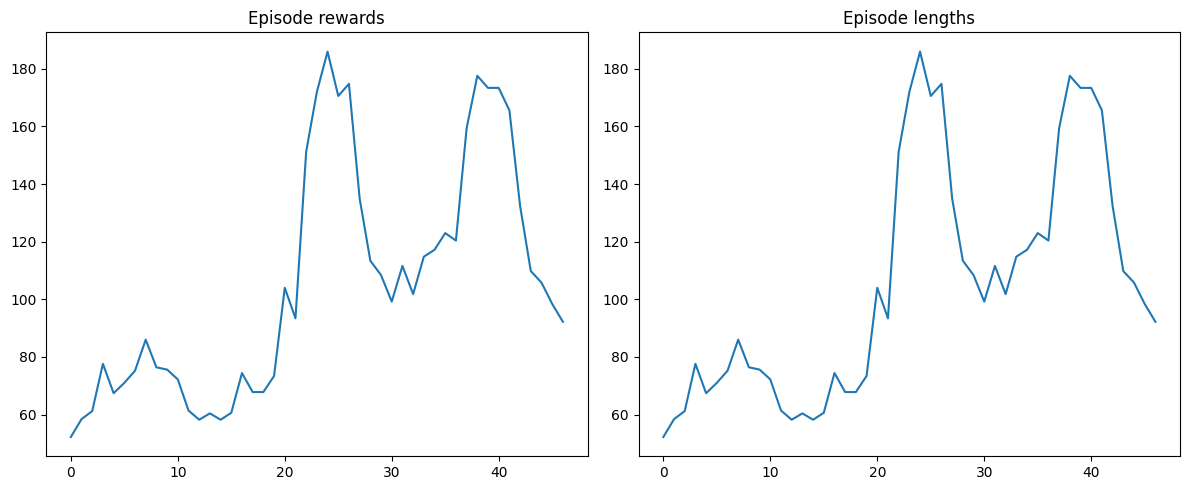

In [16]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [17]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 10

In [18]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 200

In [19]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [20]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [21]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

### Episode 50

In [22]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-50.mp4")